In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from lingam import DirectLiNGAM, CausalBasedSimulator
from lingam.utils import make_dot

np.random.seed(0)

# 1. DirectLiNGAM

## 1.1. sinkが連続のとき

### テストデータ

DirectLiNGAMのexampleにsinkノードを追加。全変数につなげた。

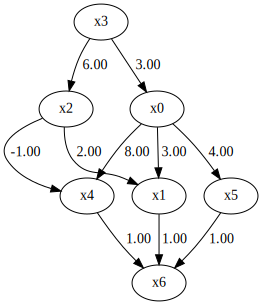

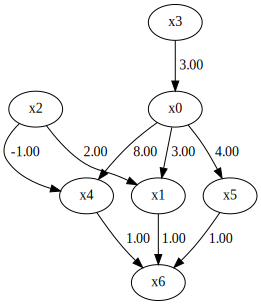

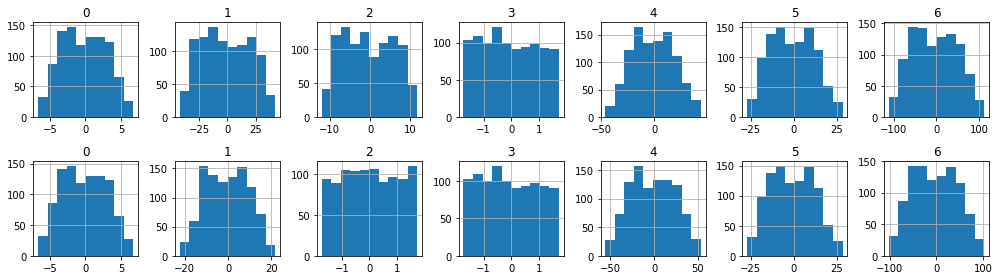

In [2]:
size = 1000

# 変更前
B_true = np.array([
    [0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0],
    [3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [8.0, 0.0,-1.0, 0.0, 0.0, 0.0, 0.0],
    [4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0],
])

e_true = np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(len(B_true), size))

# 変更後
B2_true = B_true.copy()

# 操作: x3->x2のエッジを削除
B2_true[2, 3] = 0

# 同じ誤差項を使う
#e2_true = np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(len(B2_true), size))

# データ
X = np.linalg.pinv(np.eye(len(B_true)) - B_true) @ e_true
X = X.T

X2 = np.linalg.pinv(np.eye(len(B2_true)) - B2_true) @ e_true
X2 = X2.T

display(make_dot(B_true))
display(make_dot(B2_true))

fig, axes = plt.subplots(2, 7, figsize=(14, 4))
pd.DataFrame(X).hist(ax=axes[0])
pd.DataFrame(X2).hist(ax=axes[1])
plt.tight_layout()

## DAGの作成

ユーザが描いたDAGか、因果探索した結果なので、今回は後者を使う。

In [3]:
model = DirectLiNGAM()
model.fit(X)

estimated_dag = model.adjacency_matrix_

pd.DataFrame(estimated_dag).style.background_gradient(axis=None)

,0,1,2,3,4,5,6
0,0.000000,0.000000,0.000000,2.972189,0.000000,0.000000,0.000000
1,2.996585,0.000000,1.997898,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,6.046655,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,8.015729,0.000000,-1.005115,0.000000,0.000000,0.000000,0.000000
5,3.998317,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,1.003300,0.000000,0.000000,1.012330,0.971952,0.000000


## シミュレーション

B2と同じように操作した場合をシミュレーションする。

In [4]:
x = pd.DataFrame(X, columns=pd.MultiIndex.from_tuples([("X", i) for i in range(7)]))
display(x.columns)

from sklearn.utils import check_array
x = check_array(x.columns, ensure_2d=False, dtype=None)
[str(x_) for x_ in x]

MultiIndex([('X', 0),
            ('X', 1),
            ('X', 2),
            ('X', 3),
            ('X', 4),
            ('X', 5),
            ('X', 6)],
           )

["('X', 0)",
 "('X', 1)",
 "('X', 2)",
 "('X', 3)",
 "('X', 4)",
 "('X', 5)",
 "('X', 6)"]

In [5]:
sim = CausalBasedSimulator()
sim.train(pd.DataFrame(X), estimated_dag, cd_algo_name="DirectLiNGAM")

print(sim.train_result_.keys())

# x2のモデルを変更したい。
sim.train_result_["2"].keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6'])


dict_keys(['model', 'parent_names', 'predicted', 'residual'])

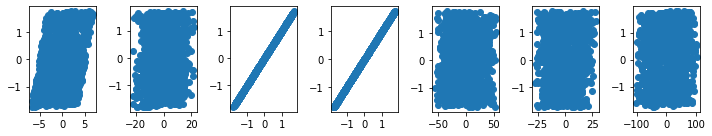

In [6]:
changing_models = {
    # 親は必須。モデルまたはcoefsのどちらかが必須。親なしで何らかのモデルを設定して、残差だけ足すみたいなことができるように。
    "2": {"parent_names": None, "model": None},
}

simulated = sim.run(changing_models=changing_models, shuffle_residual=False)

fig, axes = plt.subplots(1, len(simulated.columns), figsize=(10, 2))
for i, endog_name in enumerate(simulated.columns):
    axes[i].scatter(simulated[endog_name], sim.train_result_[endog_name]["residual"])
plt.tight_layout()
plt.show()

x2のシミュレーション結果が残差と等しくなっている様子が確認できる。

### 機械学習


***  LinearRegression()  ***
1.067134686276398 1.0784553235463132


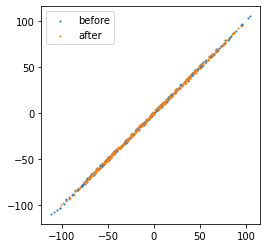


***  RandomForestRegressor()  ***
4.534434890320638 3.96709846534216


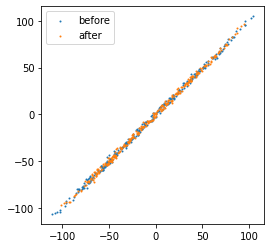

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

models = [
    LinearRegression(),
    RandomForestRegressor(),
]

for model in models:
    print("\n*** ", model, " ***")

    split = int(len(X) * 0.7)
    
    # 元データで機械学習
    model.fit(X[:split, :-1], X[:split, -1])
    y_hat = model.predict(X[split:, :-1])

    # シミュレートデータで機械学習
    model.fit(simulated.iloc[:split, :-1], simulated.iloc[:split, -1])
    y2_hat = model.predict(simulated.iloc[split:, :-1])
    
    # 評価
    value = mean_squared_error(X[split:, -1], y_hat)
    value2 = mean_squared_error(X2[split:, -1], y2_hat)
    print(value, value2)

    # 散布図
    # 横軸は真のデータ、縦軸は予測データ。
    # 青はモデル変更前の結果、橙はモデル変更後の結果
    plt.scatter(X[split:, -1], y_hat, s=1, label="before")
    plt.scatter(X2[split:, -1], y2_hat, s=1, label="after")
    plt.gca().set_aspect("equal", "box")
    plt.legend()
    plt.show()

## 1.2. sinkが離散のとき

連続のときと同じように作成するが、最後にexpitに入力して2値化する。

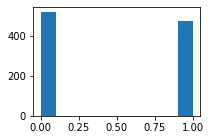

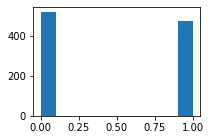

In [8]:
from scipy.special import expit

# sinkを離散化
X_d = X.copy()
X_d[:, -1] = expit(X_d[:, -1]) > 0.5

X_d2 = X2.copy()
X_d2[:, -1] = expit(X_d2[:, -1]) > 0.5

# 可視化
plt.figure(figsize=(3, 2))
plt.hist(X_d[:, -1])
plt.show()
plt.figure(figsize=(3, 2))
plt.hist(X_d2[:, -1])
plt.show()

因果探索を実行する。sinkは離散になるので抜いておく。

In [9]:
model = DirectLiNGAM()
model.fit(X_d[:, :-1])

estimated_dag = model.adjacency_matrix_

さらにsinkへのエッジを枝刈りしつつ推定する。

In [10]:
# ada_logisitic_regressionのフォルダで実行するか持ってくるかしておく。
from ada_logistic_reg import predict_adaptive_logistic_regression

predictor_indices = np.arange(6)
target_index = 6
coef = predict_adaptive_logistic_regression(X_d, predictor_indices, target_index, gamma=0.01)

# 係数を隣接行列に結合する
concated_dag = np.zeros((X.shape[1], X.shape[1]))
# 因果探索結果
concated_dag[:-1, :-1] = estimated_dag
# 枝刈り結果
concated_dag[-1, :-1] = coef

# ※sinkが一番右の列だからいいけど、そうでなければ面倒になる。sinkは最右列にしてもらうことにすれば楽。あるいは内部的にそうしてしまうか。

In [11]:
pd.DataFrame(concated_dag).style.background_gradient(axis=None)

,0,1,2,3,4,5,6
0,0.000000,0.000000,0.000000,2.972189,0.000000,0.000000,0.000000
1,2.996585,0.000000,1.997898,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,6.046655,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,8.015729,0.000000,-1.005115,0.000000,0.000000,0.000000,0.000000
5,3.998317,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,1.349478,0.000000,0.000000,1.147617,1.355227,0.000000


参考に正解を表示する。エッジの有無はあっている。離散変数への値が少し違うか。

In [12]:
pd.DataFrame(B_true).style.background_gradient(axis=None)

,0,1,2,3,4,5,6
0,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
1,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,8.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
5,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000


## 色々実験する必要があるので、ここまでを関数化

In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from lingam import DirectLiNGAM, CausalBasedSimulator
from lingam.utils import make_dot

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

np.random.seed(0)


def run(cd_model, B, B2, e, sink_index, changing_models, changing_exog, is_discrete, ml_models):
    """
    cd_model: 因果探索モデル
    B: 正解の隣接行列
    e: 正解の誤差項
    B2: 正解の隣接行列(モデル変更後)
    changing_models: モデル変更情報
    changing_exog: モデル変更情報(誤差項)
    """

    # データ作成
    X = np.linalg.pinv(np.eye(len(B)) - B) @ e
    X = X.T

    X2 = np.linalg.pinv(np.eye(len(B2)) - B2) @ e
    X2 = X2.T

    # 離散化
    if is_discrete:
        X[:, sink_index] = expit(X[:, sink_index]) > 0.5
        X2[:, sink_index] = expit(X2[:, sink_index]) > 0.5

    # 処理が面倒になるのでsinkを最右列に移動する。
    tmp = np.append(np.delete(np.arange(len(B)), sink_index), sink_index)
    B = B[tmp][:, tmp]
    B2 = B2[tmp][:, tmp]
    e = e[:, tmp]
    
    # 因果探索
    cd_model.fit(X)
    estimated_dag = cd_model.adjacency_matrix_
    
    # シミュレーション
    sim = CausalBasedSimulator()
    sim.train(pd.DataFrame(X), estimated_dag)
    simulated = sim.run(changing_models=changing_models, changing_exog=changing_exog, shuffle_residual=False)

    # 機械学習による予測
    for ml_model in ml_models:
        print("\n*** ", ml_model, " ***")

        # 元データで機械学習
        ml_model.fit(X[:, :-1], X[:, -1])
        y_hat = ml_model.predict(X[:, :-1])

        # シミュレートデータで機械学習
        ml_model.fit(simulated.iloc[:, :-1], simulated.iloc[:, -1])
        y2_hat = ml_model.predict(simulated.iloc[:, :-1])

        # 評価
        value = mean_squared_error(X[:, -1], y_hat)
        value2 = mean_squared_error(X2[:, -1], y2_hat)
        print("MSE", value, value2)

        # 散布図
        plt.scatter(X[:, -1], y_hat, s=1)
        plt.scatter(X2[:, -1], y2_hat, s=1)
        plt.gca().set_aspect("equal", "box")
        plt.show()

cd_model = DirectLiNGAM()

B = np.array([
    [0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0],
    [3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [8.0, 0.0,-1.0, 0.0, 0.0, 0.0, 0.0],
    [4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0],
])

e = np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(len(B_true), size))

B2 = B.copy()
B2[2, 3] = 0

sink_index = 6

# 常に0を返すダミーリグレッサー
reg_model = DummyRegressor(strategy="constant", constant=0.0)
reg_model.fit(
    [[0.0 for _ in range(len(sim.train_result_[2][0]["exp_columns"]))]],
    [[0.0]]
)
changing_models = [{
    "name": 2,
    "model": reg_model,
    "condition": None
}]

changing_errors = None

is_discrete = False

ml_models = [
    LinearRegression(),
    RandomForestRegressor(),
]

run(cd_model, B, B2, e, sink_index, changing_models, changing_errors, is_discrete, ml_models)

KeyError: 2